# Utility development
Now that we have decoded spike traces from the Corbo dataset out of MATLAB and into HDF5 files, we need to have commands that can query this data.

The purpose of this notebook is to understand what commands we need to develop and to develop those commands.

**Update:** The utilities developed in this notebook do not access data in an efficient manner and leave out important inclusion criteria for neurons. This notebook does provide a generally readable introduction to functions used to access the Corbo data.

## Imports

In [1]:
%cd ../../

/home/jovyan/work/task-priors


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import h5py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.data_access import load_tables, retrieve_experiment_ids

In [4]:
rng = np.random.default_rng(12345)

In [5]:
tables = load_tables()
df_celltable, df_trialtable = tables
experiment_ids = retrieve_experiment_ids(tables)

/home/jovyan/work/task-priors/src/data_access.py:21: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_celltable = pd.read_csv(DATASET['CellTable_path'])


## Workbench

In [6]:
df_celltable[df_celltable['Best_Fit_spikes_2'].isin([np.nan])]['Best_Fit_spikes_1'].unique()

array([nan], dtype=object)

In [7]:
len(np.sort(df_celltable['Pref_Orientation_spikes_2'].unique()))

361

## Retrieve Experiment IDs that meet criteria

In [8]:
from src.data_access import retrieve_relevant_experiment_ids

In [9]:
relevant_experiment_ids = retrieve_relevant_experiment_ids(45, 'Visual', tables)
len(relevant_experiment_ids)

60

In [10]:
unique_visual_stim = df_trialtable[['Experiment', 'Block', 'Visual_Stim']].drop_duplicates()
visual_45 = unique_visual_stim[
    (unique_visual_stim['Visual_Stim'] == 45) &\
    (unique_visual_stim['Block'] == 'Visual')
]
visual_45_experiments = list(visual_45['Experiment'])
len(visual_45_experiments)

60

In [11]:
sorted(visual_45_experiments) == sorted(relevant_experiment_ids)

True

In [12]:
relevant_experiment_ids = retrieve_relevant_experiment_ids(60, 'Visual', tables)
len(relevant_experiment_ids)

10

## Retrieve admissible neurons

In [13]:
from src.data_access import retrieve_admissible_neurons

In [14]:
admissible_neurons = retrieve_admissible_neurons(visual_45_experiments, tables)
admissible_neurons.head()

,Cell,Experiment,Best_Fit_spikes_2,Pref_Orientation_spikes_2
3,4,B10_110920,circular_gaussian_180,94.0
5,6,B10_110920,direction_selective_circular_gaussian,13.0
6,7,B10_110920,circular_gaussian_360,126.0
8,9,B10_110920,circular_gaussian_360,145.0
9,10,B10_110920,circular_gaussian_360,170.0


## Sample 250 neurons
We gotta ensure that it's reproducible!

In [15]:
sampled_neurons = admissible_neurons.sample(250, random_state=42, replace=False)
sampled_neurons.head()

,Cell,Experiment,Best_Fit_spikes_2,Pref_Orientation_spikes_2
19086,951,C05_121120,circular_gaussian_360,126.0
43922,529,F07_42321_,circular_gaussian_360,261.0
21865,292,C05_121420,circular_gaussian_360,261.0
61918,272,F10_42621_,circular_gaussian_180,105.0
49824,100,F09_42221_,circular_gaussian_180,148.0


In [16]:
sampled_neurons.equals(admissible_neurons.sample(250, random_state=42, replace=False))

True

In [17]:
sampled_neurons.equals(admissible_neurons.sample(250, random_state=69, replace=False))

False

## Construct trial bank per experiment

In [18]:
from src.data_access import construct_trial_bank

In [19]:
trial_bank = construct_trial_bank(visual_45_experiments, tables,)

trial_array = trial_bank[visual_45_experiments[0]]
rng.choice(trial_array).item(), rng.choice(trial_array).item()

(293, 96)

## Retrieve spike trace

In [20]:
from src.data_access import retrieve_spike_trace

In [21]:
experiment_id = 'B10_110920'
trial_number = 101
cell_number = 12

In [22]:
CellTrialTabel_csv_path = './data/DATASET1_CellTrialTable'
hdf5_path = os.path.join(CellTrialTabel_csv_path, experiment_id[:3], f"{experiment_id}.h5")
hdf5_path

'./data/DATASET1_CellTrialTable/B10/B10_110920.h5'

In [23]:
with h5py.File(hdf5_path, 'r') as hdf:
    trial_name = f'trial_{trial_number}'
    cell_trial_spike_train_test = hdf[trial_name][:,cell_number]

In [24]:
cell_trial_spike_train = retrieve_spike_trace(experiment_id, trial_number, cell_number)

In [25]:
np.array_equal(cell_trial_spike_train_test, cell_trial_spike_train)

False

## Sample trial and retrieve spike trace
Let's combine the previous two functions into one.

In [26]:
from src.data_access import sample_trial_and_retrieve_trace

In [27]:
sample_trial_and_retrieve_trace(rng, sampled_neurons.iloc[11], trial_bank)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

## Distribution of spike trace length

In [28]:
from src.data_access import sample_trial_and_retrieve_trace_FAST

This was a good exercise in indexing all spike traces in HDF5 files. However, it took 50 minutes and 6 seconds to access `69,317` spike traces, so be warned.

The shortest trace length was `83`. The longest trace length was `211`.

## Grouping spike traces by orientation
Now that we can access spike traces for a tuple of (experiment_id, tiral_id, cell_id), we want to group these traces by the preferred orientation of the neuron that produced the spike trace.

I'm thinking that this grouping can happen via a running sum and counter. Spike traces are added to the running sum and the counter is increased. As the end of the generation of resampled trials, the running sums are devided by the counter producing the average.

The running sum will be a matrix of size `(360, 211)` where `360` is the number of preferred orientations in degrees and `211` is the maximum length of a spike trace.

The counter will be an array of size `(360,)` where `360` is the number of preferred orientations in degrees.

In [29]:
# Via the neuron row, we can access the preferred orientation
pref_orientation = int(sampled_neurons.iloc[11]['Pref_Orientation_spikes_2'].item())
pref_orientation

263

In [30]:
# We need to pad spike traces such that their lengths all equal `211`
desired_len = 211
spike_trace = sample_trial_and_retrieve_trace(rng, sampled_neurons.iloc[11], trial_bank)
padded_spike_trace = np.pad(spike_trace, (0, desired_len-len(spike_trace)), mode='constant')
padded_spike_trace.shape

(211,)

## Filter trial bank
- In the `retrieve_relevant_experiment_ids(45, 'Visual', tables)` function call, we find experiments with the stimulus group of interest.
- In the `construct_trial_bank(visual_45_experiments, tables,)` function call, we did not select trials with the stimulus group of interest.

In [31]:
from src.data_access import construct_filtered_trial_bank

In [32]:
filtered_trial_bank = construct_filtered_trial_bank(visual_45_experiments, 45, 'Visual', tables,)

## Test functions

In [33]:
orientations = 360
max_trace_len = 211

running_sum_mat = np.zeros((orientations, max_trace_len))
counter = np.zeros(orientations)

sampled_neurons_TEST = admissible_neurons.sample(10000, random_state=42, replace=True)
for row in tqdm(sampled_neurons_TEST.itertuples()):
    pref_orientation = int(row.Pref_Orientation_spikes_2)
    orientation_index = pref_orientation - 1 # I will forget about this and be sorry

    trace_array = sample_trial_and_retrieve_trace_FAST(rng, row, filtered_trial_bank)
    padded_spike_trace = np.pad(trace_array, (0, max_trace_len-len(trace_array)), mode='constant')

    running_sum_mat[orientation_index, :] += padded_spike_trace
    counter[orientation_index] += 1

10000it [18:03,  9.23it/s]


In [34]:
average_spike_trace_per_orientation = np.divide(running_sum_mat, counter[:, None], where=counter[:, None] != 0)
average_spike_trace_per_orientation = np.nan_to_num(average_spike_trace_per_orientation)

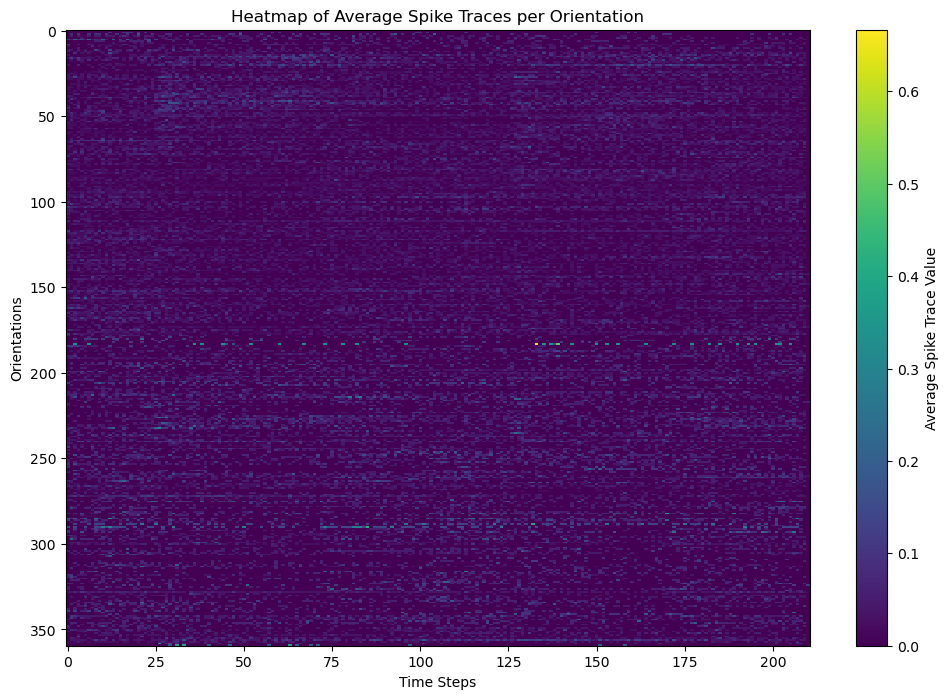

In [35]:
plt.figure(figsize=(12, 8))
plt.imshow(average_spike_trace_per_orientation, aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label='Average Spike Trace Value')
plt.title('Heatmap of Average Spike Traces per Orientation')
plt.xlabel('Time Steps')
plt.ylabel('Orientations')
plt.show()

In [36]:
from scipy.ndimage import gaussian_filter1d

baseline_subtracted_matrix = average_spike_trace_per_orientation - np.mean(average_spike_trace_per_orientation, axis=1, keepdims=True)
gaussian_sd_in_rows = 6
smoothed_matrix = gaussian_filter1d(baseline_subtracted_matrix, sigma=gaussian_sd_in_rows, axis=0, mode='wrap')

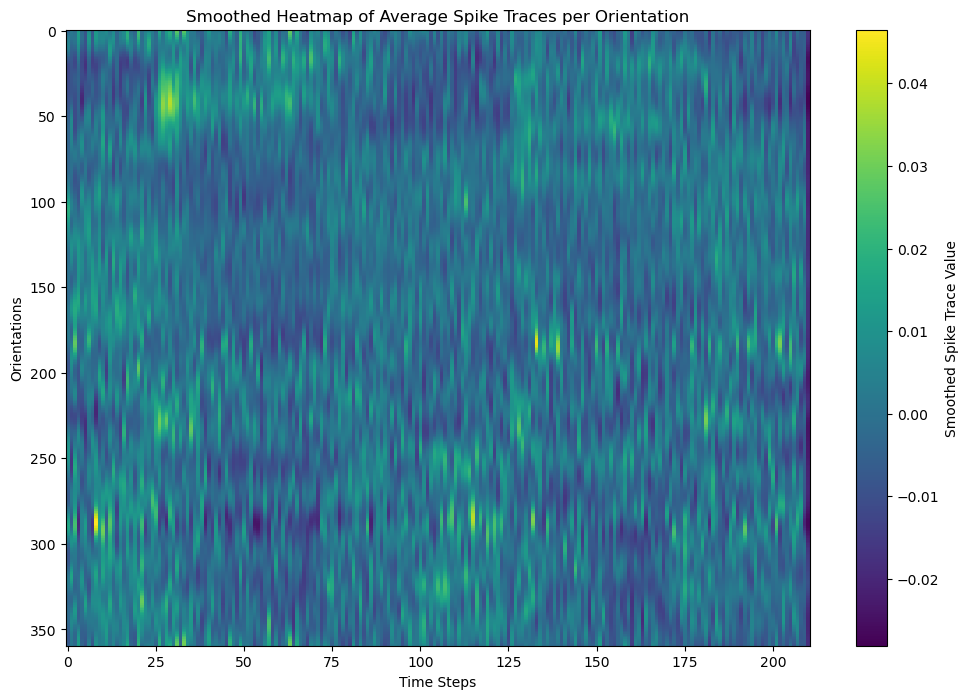

In [37]:
plt.figure(figsize=(12, 8))
plt.imshow(smoothed_matrix, aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label='Smoothed Spike Trace Value')
plt.title('Smoothed Heatmap of Average Spike Traces per Orientation')
plt.xlabel('Time Steps')
plt.ylabel('Orientations')
plt.show()